In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize
from scipy.ndimage import gaussian_filter

from google.colab import drive
import os

drive.mount('/content/drive')
save_dir = "/content/drive/My Drive/Papers/BNOT"
os.makedirs(save_dir, exist_ok=True)

Mounted at /content/drive


In [ ]:
# ---- Constants ----
eps0 = 8.854187817e-12
c    = 2.99792458e8
hbar = 6.626*1e-34/2/np.pi


# ---- Device parameters (example values, replace with yours) ----
d_eff = 19.5e-12*(2/np.pi)  # [m/V]
d33 = d_eff*np.pi/2  # [m/V]
L = 1e-3               # [m]
S_2omega = 8e-13       # [m^2]
S_omega  = 10e-13        # [m^2]
lambda_omega = 1550e-9             # [m]
n_omega      = 2.14
n_2omega     = 2.2
omega = 2*np.pi*c/lambda_omega

Gamma_omega_dB = 5             # [dB/m]
Gamma_2omega_dB = 10           # [dB/m]
Gamma_omega = Gamma_omega_dB/10*np.log(10)
Gamma_2omega = Gamma_2omega_dB/10*np.log(10)



Delta_k_mean = 0           # [1/m]
Delta_k_std = 0.36         # [1/m]


# Uncertainty / noise levels
power_fluctuation_sqz = 0.005
power_fluctuation_shg = 0.005


# Photon numbers & their uncertainty windows
uncertainty_range_sqz = (1 - power_fluctuation_sqz, 1 + power_fluctuation_sqz)
uncertainty_range_shg = (1 - power_fluctuation_shg, 1 + power_fluctuation_shg)

Sqz_noise_std = 0.1 #  dB
SHG_noise_std =  20 #  %/W/cm^2

# Example: pick nominal pump powers (in mW) around which you add fluctuations
ppsqz_nominal_mW = 100.0   # mean pump power for squeezing (at 2ω)
ppshg_nominal_mW  = 10.0   # mean pump power for SHG (at ω)


In [ ]:
# ---- Helpers ----
def G(x,y):
    return 1+np.exp(-2*x)-2*np.exp(-x)*np.cos(y)


def sinc(x):
    return np.sinc(x/np.pi)   # numpy's sinc is sin(pi x)/(pi x)


def simulate_Sqz(ppsqz_mW, x1, x2):
    P2w_on = x1 * (np.asarray(ppsqz_mW) * 1e-3)   # W
    Delta_k = np.random.normal(Delta_k_mean,Delta_k_std)  #[1/m]
    alpha = np.sqrt(n_2omega*L/2/c/hbar/omega)  # [1/W]

    S_on   = 2 * np.sqrt(alpha * P2w_on) * np.abs(sinc(0.5 * Delta_k * L))
    V_numerical = 1 - x2 * (1 - np.exp(-2*S_on))
    return -10*np.log10(V_numerical + 1e-9)

# ---- SHG (fundamental at ω from RIGHT) ----
def simulate_SHGeff(ppshg_mW, x1, x2):
    Pw_on = (np.asarray(ppshg_mW) * 1e-3)     # W
    Delta_k = np.random.normal(Delta_k_mean,Delta_k_std)  #[1/m]
    beta = 8*d33**2/(n_omega**2*n_2omega*eps0*c*(lambda_omega/2)**2)*(S_2omega/S_omega**2)/(Delta_k**2*L**2+Gamma_2omega**2*L**2/4)     # [1/W/m^2]

    E_on  = beta * G(Gamma_2omega*L/2, Delta_k * L)/100**2*100     # [%/W/cm^2]
    return x1 * x2**2 * E_on                                       # [%/W/cm^2]

## Cost function
def cost_fixed_alpha(params, sqz_numerical, shg_numerical, ppsqz, pphg):
    eta1, eta2 = params
    sqz_pred = simulate_Sqz(ppsqz, eta1, eta2)
    shg_pred = simulate_SHGeff(pphg, eta1, eta2)
    term1 = ((sqz_pred - sqz_numerical) / sqz_numerical) ** 2
    term2 = ((shg_pred - shg_numerical) / shg_numerical) ** 2
    return term1 + term2

# Fig.2

## (a), (b)

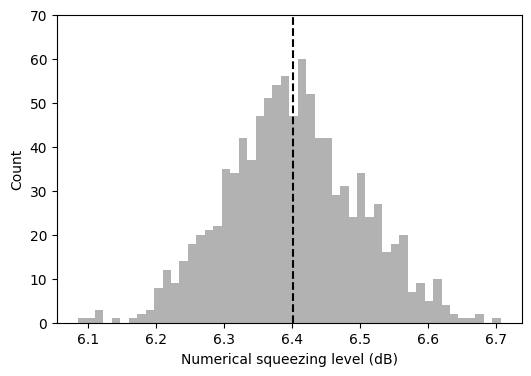

Squeezing level mean: 6.40 dB
95% CI: [6.22, 6.60] dB


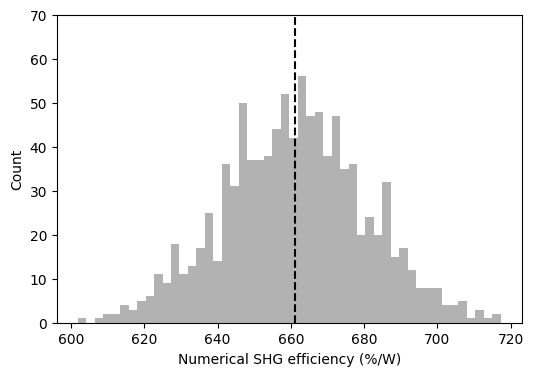

SHG efficiency mean: 661.07 %
95% CI: [622.75, 699.65] %


In [ ]:
np.random.seed(123)

# Draw random pump powers directly in mW
ppsqz_sample = np.random.uniform(*uncertainty_range_sqz) * ppsqz_nominal_mW
ppshg_sample = np.random.uniform(*uncertainty_range_sqz) * ppshg_nominal_mW



n_trials    = 1000
sqz_num_arr = np.empty(n_trials)
shg_num_arr = np.empty(n_trials)

eta_1_true = 0.734
eta_2_true = 0.771

for j in range(n_trials):
    # 1) get ideal predictions
    sqz_ideal = simulate_Sqz(ppsqz_sample, eta_1_true, eta_2_true)      # dB
    shg_ideal = simulate_SHGeff(ppshg_sample,eta_1_true, eta_2_true)    # %

    # 2) add measurement noise
    sqz_num = sqz_ideal + np.random.normal(0, Sqz_noise_std)
    shg_num = shg_ideal + np.random.normal(0, SHG_noise_std)
    sqz_num_arr[j] = sqz_num
    shg_num_arr[j] = shg_num

# ---- Post-processing squeezing results ----
mean_val = np.mean(sqz_num_arr)
lower = np.percentile(sqz_num_arr, 2.5)
upper = np.percentile(sqz_num_arr, 97.5)

plt.figure(figsize=(6,4))
counts, bins, _ = plt.hist(sqz_num_arr, color='gray', bins=50, alpha=0.6)
plt.axvline(mean_val, linestyle='--', color='black', label=f'Mean = {mean_val:.2f} dB')
# plt.axvspan(lower, upper, color='gray', alpha=0.2, label='95% CI')
plt.xlabel('Numerical squeezing level (dB)')
plt.ylabel('Count')
plt.ylim(0, 70)

save_path = save_dir+f"/Fig2a.png"
os.makedirs(os.path.dirname(save_path), exist_ok=True)
plt.savefig(save_path, dpi=1200)

# plt.legend()
plt.show()

print(f"Squeezing level mean: {mean_val:.2f} dB")
print(f"95% CI: [{lower:.2f}, {upper:.2f}] dB")

# ---- Post-processing SHG results ----
mean_val = np.mean(shg_num_arr)
lower = np.percentile(shg_num_arr, 2.5)
upper = np.percentile(shg_num_arr, 97.5)

plt.figure(figsize=(6,4))
counts, bins, _ = plt.hist(shg_num_arr, color='gray', bins=50, alpha=0.6)
plt.axvline(mean_val, linestyle='--', color='black', label=f'Mean = {mean_val:.2f} %')
# plt.axvspan(lower, upper, color='gray', alpha=0.2, label='95% CI')
plt.xlabel('Numerical SHG efficiency (%/W)')
plt.ylabel('Count')
plt.ylim(0, 70)
# plt.xlim(0, 3000)
# plt.legend()

save_path = save_dir+f"/Fig2b.png"
os.makedirs(os.path.dirname(save_path), exist_ok=True)
plt.savefig(save_path, dpi=1200)

plt.show()

print(f"SHG efficiency mean: {mean_val:.2f} %")
print(f"95% CI: [{lower:.2f}, {upper:.2f}] %")

## (c)

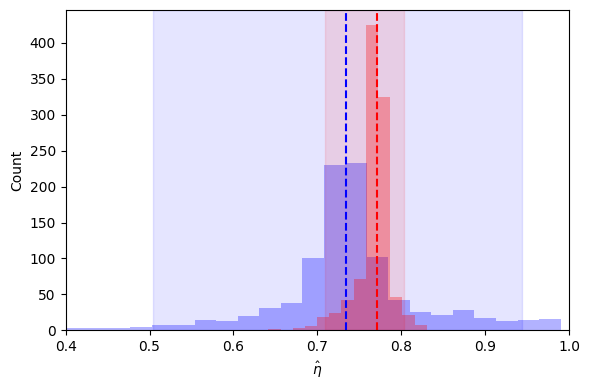

True η₁ = 0.734 and η₂ = 0.771 (squeezing: 6.40 dB, SHG efficiency: 660 %)
Estimated η₁ 95% CI: [0.504, 0.945]  (mean 0.735)
Estimated η₂ 95% CI: [0.709, 0.803]  (mean 0.766)


In [ ]:
numb = 1000        # Num ber of trials for Monte Carlo simulation

np.random.seed(97)

# Parameter bounds
lower_limit, upper_limit = 0.01, 0.99

eta_1_true = 0.734
eta_2_true = 0.771


ppsqz_sample = np.random.uniform(*uncertainty_range_sqz) * ppsqz_nominal_mW  # mW, 2ω
ppshg_sample  = np.random.uniform(*uncertainty_range_shg) * ppshg_nominal_mW   # mW, ω

# Ideal (noise-free) outputs
sqz_ideal = simulate_Sqz(ppsqz_sample, eta_1_true, eta_2_true)   # dB
shg_ideal = simulate_SHGeff(ppshg_sample , eta_1_true, eta_2_true) # %



# ─────────────────────────── Bootstrap loop ───────────────────────────────
x1, x2 = [], []
for _ in range(numb):
    # synthetic numerical data with noise
    sqz_num = sqz_ideal + np.random.normal(0, Sqz_noise_std)
    shg_num = shg_ideal + np.random.normal(0, SHG_noise_std)

    res = minimize(
        cost_fixed_alpha,
        x0=[np.random.uniform(lower_limit, upper_limit),
            np.random.uniform(lower_limit, upper_limit)],
        args=(sqz_num, shg_num, ppsqz_sample, ppshg_sample),
        bounds=[(lower_limit, upper_limit), (lower_limit, upper_limit)],
        method='L-BFGS-B'
    )
    est1, est2 = res.x
    x1.append(est1)
    x2.append(est2)

eta_1_pred = np.array(x1)
eta_2_pred = np.array(x2)
eta_1_ci = np.percentile(eta_1_pred, [2.5, 97.5])
eta_2_ci = np.percentile(eta_2_pred, [2.5, 97.5])
eta_1_mean = eta_1_pred.mean()
eta_2_mean = eta_2_pred.mean()

# Nominal values for reporting
sqz_nominal_db  = simulate_Sqz(ppsqz_sample, eta_1_true, eta_2_true)      # dB (likely negative)
shg_nominal_pct = simulate_SHGeff(ppshg_sample, eta_1_true, eta_2_true)    # %

# ────────────────────────────── Plotting ───────────────────────────────────
# η1
plt.figure(figsize=(6,4))
plt.hist(eta_1_pred, bins=30, alpha=0.3, color='blue')
# plt.axvline(eta1_mean, color='k', linestyle='--', linewidth=1.5, label=r'Mean $\hat{\eta}_1$')
plt.axvline(eta_1_true, linestyle='--', color='blue',  label=r'True $\eta_1$')
plt.axvspan(eta_1_ci[0], eta_1_ci[1], color='blue', alpha=0.1, label='95% CI')

plt.hist(eta_2_pred, bins=30, alpha=0.3, color='red')
# plt.axvline(eta2_mean, color='k', linestyle='--', linewidth=1.5, label=r'Mean $\hat{\eta}_2$')
plt.axvline(eta_2_true, linestyle='--', color='red',  label=r'True $\eta_2$')
plt.axvspan(eta_2_ci[0], eta_2_ci[1], color='red', alpha=0.1, label='95% CI')

plt.xlabel(r'$\hat{\eta}$')
plt.ylabel('Count')
plt.xlim(0.4, 1)
# plt.ylim(0, 90)
# plt.legend()
plt.tight_layout()

save_path = save_dir+f"/Fig2c.png"
os.makedirs(os.path.dirname(save_path), exist_ok=True)
plt.savefig(save_path, dpi=1200)

plt.show()

print(f"True η₁ = {eta_1_true:.3f} and η₂ = {eta_2_true:.3f} "
      f"(squeezing: {sqz_nominal_db:.2f} dB, SHG efficiency: {shg_nominal_pct:.3g} %)")
print(f"Estimated η₁ 95% CI: [{eta_1_ci[0]:.3f}, {eta_1_ci[1]:.3f}]  (mean {eta_1_mean:.3f})")
print(f"Estimated η₂ 95% CI: [{eta_2_ci[0]:.3f}, {eta_2_ci[1]:.3f}]  (mean {eta_2_mean:.3f})")


# Fig. 3

In [ ]:
num_repeats = 200          # repeated trials per grid point (set ≥1)
numb   = 100
start  = 1 / numb
end    = 1.0
sweep_eta1_range = np.linspace(start, end, numb)
sweep_eta2_range = np.linspace(start, end, numb)

In [ ]:
# --------------- Containers ----------------
eta1_err = np.zeros((numb, numb))
eta2_err = np.zeros((numb, numb))
est_eta1 = np.zeros((numb, numb))
est_eta2 = np.zeros((numb, numb))

# --------------- Sweep & fit ----------------
for i, eta1_true in enumerate(sweep_eta1_range):
    for j, eta2_true in enumerate(sweep_eta2_range):

        est_list_eta1, est_list_eta2 = [], []
        err_list_eta1, err_list_eta2 = [], []

        for _ in range(num_repeats):
            # single photon‑power sample per experiment
            ppsqz_sample = np.random.uniform(*uncertainty_range_sqz) * ppsqz_nominal_mW
            ppshg_sample  = np.random.uniform(*uncertainty_range_shg) * ppshg_nominal_mW


            # noisy numerical data
            sqz_num = simulate_Sqz(ppsqz_sample, eta1_true, eta2_true) + np.random.normal(0, Sqz_noise_std)
            shg_num = simulate_SHGeff(ppshg_sample, eta1_true, eta2_true) + np.random.normal(0, SHG_noise_std)

            # fit (random start inside bounds)
            res = minimize(
                cost_fixed_alpha,
                x0=[np.random.uniform(start, end), np.random.uniform(start, end)],
                args=(sqz_num, shg_num, ppsqz_sample, ppshg_sample),
                bounds=[(start, end), (start, end)],
                method='L-BFGS-B'
            )
            eta1_hat, eta2_hat = res.x
            est_list_eta1.append(eta1_hat)
            est_list_eta2.append(eta2_hat)

            err_list_eta1.append(abs(eta1_hat - eta1_true)**2)
            err_list_eta2.append(abs(eta2_hat - eta2_true)**2)

        # average over repeats
        est_eta1[j, i] = np.mean(est_list_eta1)
        est_eta2[j, i] = np.mean(est_list_eta2)
        eta1_err[j, i] = np.sqrt(np.mean(err_list_eta1))
        eta2_err[j, i] = np.sqrt(np.mean(err_list_eta2))
    print(f"Remaining steps : {numb-i}")

np.save(save_dir+"/est_eta1.npy", est_eta1)
np.save(save_dir+"/est_eta2.npy", est_eta2)
np.save(save_dir+"/eta1_err.npy", eta1_err)
np.save(save_dir+"/eta2_err.npy", eta2_err)

Remaining steps : 100
Remaining steps : 99
Remaining steps : 98
Remaining steps : 97
Remaining steps : 96
Remaining steps : 95
Remaining steps : 94
Remaining steps : 93
Remaining steps : 92
Remaining steps : 91
Remaining steps : 90
Remaining steps : 89
Remaining steps : 88
Remaining steps : 87
Remaining steps : 86
Remaining steps : 85
Remaining steps : 84
Remaining steps : 83
Remaining steps : 82
Remaining steps : 81
Remaining steps : 80
Remaining steps : 79
Remaining steps : 78
Remaining steps : 77
Remaining steps : 76
Remaining steps : 75
Remaining steps : 74
Remaining steps : 73
Remaining steps : 72
Remaining steps : 71
Remaining steps : 70
Remaining steps : 69
Remaining steps : 68
Remaining steps : 67
Remaining steps : 66
Remaining steps : 65
Remaining steps : 64
Remaining steps : 63
Remaining steps : 62
Remaining steps : 61
Remaining steps : 60
Remaining steps : 59
Remaining steps : 58
Remaining steps : 57
Remaining steps : 56
Remaining steps : 55
Remaining steps : 54
Remaining st

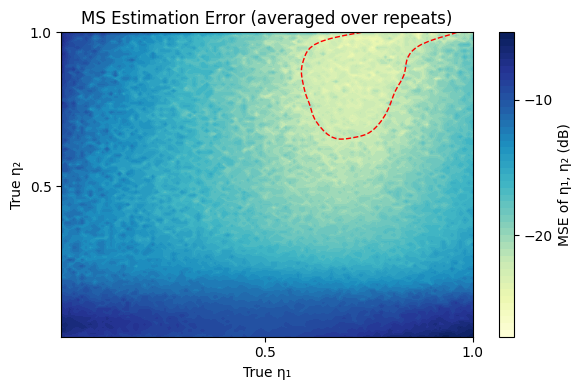

Random grid point:
True (η₁, η₂) = (0.300, 0.350)
Estimated (η₁, η₂)  = (0.391, 0.333)


In [ ]:
est_eta1 = np.load(save_dir + "/est_eta1.npy")
est_eta2 = np.load(save_dir + "/est_eta2.npy")
eta1_err = np.load(save_dir + "/eta1_err.npy")
eta2_err = np.load(save_dir + "/eta2_err.npy")

# --------------- RMS‑error plot ---------------
rms_err = np.sqrt((eta1_err**2 + eta2_err**2)/2)
ms_err_db = 10*np.log10(rms_err**2)

# smooth ONLY for visualization (does not affect arrays you print/save)
ms_err_db_smooth = gaussian_filter(ms_err_db, sigma=3.0, mode='nearest')

plt.figure(figsize=(6, 4))
cf = plt.contourf(sweep_eta1_range, sweep_eta2_range, ms_err_db, levels=50, cmap='YlGnBu')

# Smooth –20 dB contour (orange dashed)
boundary = plt.contour(
    sweep_eta1_range, sweep_eta2_range,
    ms_err_db_smooth,
    levels=[-22], colors='red', linewidths=1
)

# Only attempt to clabel if there are actual contour lines drawn
# The previous check `if boundary.collections:` caused an AttributeError,
# implying 'collections' is not always present when no contours are found.
# This more robust check verifies the attribute's existence first.
if hasattr(boundary, 'collections') and len(boundary.collections) > 0:
    plt.clabel(
        boundary, fmt='0.01', inline=True, fontsize=14,
        manual=[(0.75, 0.8)]
    )

cbar = plt.colorbar(cf)
cbar.set_label('MSE of η₁, η₂ (dB)')
cbar.set_ticks([ -10, -20])
plt.xticks([0.5,1])
plt.yticks([0.5,1])
plt.xlabel('True η₁'); plt.ylabel('True η₂')
plt.title('MS Estimation Error (averaged over repeats)')
plt.tight_layout()

save_path = save_dir+f"/Fig3a.png"
os.makedirs(os.path.dirname(save_path), exist_ok=True)
plt.savefig(save_path, dpi=1200)

plt.show()

# --------------- Example read‑out ---------------
ri, rj = np.random.randint(numb), np.random.randint(numb)
print("Random grid point:")
print(f"True (η₁, η₂) = ({sweep_eta1_range[ri]:.3f}, {sweep_eta2_range[rj]:.3f})")
print(f"Estimated (η₁, η₂)  = ({est_eta1[rj, ri]:.3f}, {est_eta2[rj, ri]:.3f})")

# # Flatten and get indices of the 10 largest values
# flat_indices = np.argpartition(rms_err.flatten(), -10)[-10:]
# # Get their row, col coordinates
# coords = np.array(np.unravel_index(flat_indices, rms_err.shape)).T
# # Get the actual values
# values = rms_err[tuple(coords.T)]

# # Sort the values and coords by actual value (descending)
# sorted_indices = np.argsort(values)
# sorted_coords = coords[sorted_indices]
# sorted_values = values[sorted_indices]

# # Print nicely
# for (i, j), val in zip(sorted_coords, sorted_values):
#     print(f"RMS Error: {val:.2f} dB, at position: ({sweep_eta1_range[i]:.2f}, {sweep_eta2_range[j]:.2f})")

In [ ]:
lower_limit, upper_limit = 0.01, 0.99

np.random.seed(17)
# ─────────────────── Generate Pump Samples ───────────────────
ppsqz_sample = np.random.uniform(*uncertainty_range_sqz) * ppsqz_nominal_mW
pphg_sample  = np.random.uniform(*uncertainty_range_shg) * ppshg_nominal_mW

# ─────────────────── Generate Random True Parameter Sets ───────────────────
num_sets = 5
eta_true_sets = np.round(np.random.uniform(lower_limit, upper_limit, size=(num_sets, 2)), 2)

# ────────────── Trial Sizes & Storage ──────────────
trial_list = 2**np.arange(1, 9)
error_eta1 = np.zeros((num_sets, len(trial_list)))
error_eta2 = np.zeros((num_sets, len(trial_list)))

# ─────────────────────── Bootstrap & Error Computation ───────────────────────
for s, (eta1_true, eta2_true) in enumerate(eta_true_sets):
    sqz_ideal = simulate_Sqz(ppsqz_sample, eta1_true, eta2_true)
    shg_ideal = simulate_SHGeff(pphg_sample, eta1_true, eta2_true)
    for i, n_trials in enumerate(trial_list):
        eta1_boot = np.empty(n_trials)
        eta2_boot = np.empty(n_trials)
        for j in range(n_trials):

            np.random.seed(2*s+j+3*i+11)

            sqz_meas = sqz_ideal + np.random.normal(0, Sqz_noise_std)
            shg_meas = shg_ideal + np.random.normal(0, SHG_noise_std)
            res = minimize(
                cost_fixed_alpha,
                x0=[np.random.uniform(lower_limit, upper_limit),
                    np.random.uniform(lower_limit, upper_limit)],
                args=(sqz_meas, shg_meas, ppsqz_sample, pphg_sample),
                bounds=[(lower_limit, upper_limit), (lower_limit, upper_limit)],
                method='L-BFGS-B'
            )
            eta1_boot[j], eta2_boot[j] = res.x
        error_eta1[s, i] = np.sqrt(np.mean((eta1_boot - eta1_true)**2))
        error_eta2[s, i] = np.sqrt(np.mean((eta2_boot- eta2_true)**2))

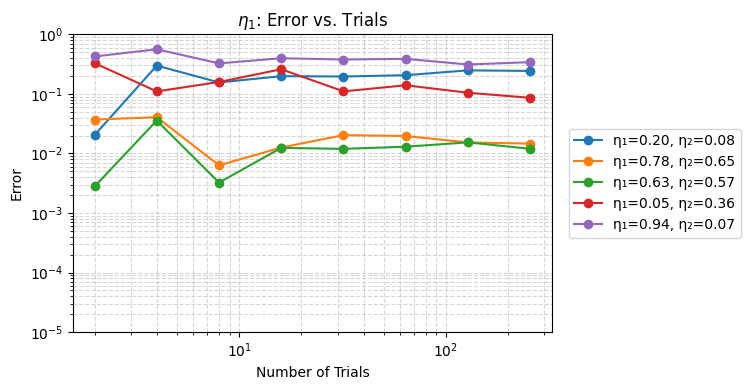

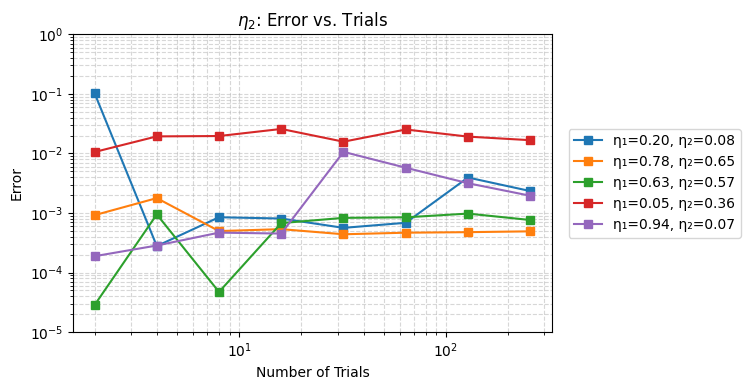

In [ ]:
# ─────────────────────── Plot η₁ Errors ───────────────────────
plt.figure(figsize=(9,4))
for s, (eta1_true, eta2_true) in enumerate(eta_true_sets):
    label = f'η₁={eta1_true:.2f}, η₂={eta2_true:.2f}'
    plt.plot(trial_list, error_eta1[s]**2, marker='o', label=label)
plt.ylim(1e-5, 1)
plt.xscale('log')
plt.yscale('log')
plt.xlabel('Number of Trials')
plt.ylabel('Error')
plt.title(r'$\eta_1$: Error vs. Trials')
plt.legend(loc='center left', bbox_to_anchor=(1.02, 0.5))
plt.tight_layout(rect=[0, 0, 0.85, 1])
plt.grid(True, which='both', ls='--', alpha=0.5)

save_path = save_dir + "/Fig3b.png"
os.makedirs(os.path.dirname(save_path), exist_ok=True)
plt.savefig(save_path, dpi=1200)
plt.show()

# ─────────────────────── Plot η₂ Errors ───────────────────────
plt.figure(figsize=(9,4))
for s, (eta1_true, eta2_true) in enumerate(eta_true_sets):
    label = f'η₁={eta1_true:.2f}, η₂={eta2_true:.2f}'
    plt.plot(trial_list, error_eta2[s]**2, marker='s', label=label)
plt.ylim(1e-5, 1)
plt.xscale('log')
plt.yscale('log')
plt.xlabel('Number of Trials')
plt.ylabel('Error')
plt.title(r'$\eta_2$: Error vs. Trials')
plt.legend(loc='center left', bbox_to_anchor=(1.02, 0.5))
plt.tight_layout(rect=[0, 0, 0.85, 1])
plt.grid(True, which='both', ls='--', alpha=0.5)

save_path = save_dir + "/Fig3c.png"
os.makedirs(os.path.dirname(save_path), exist_ok=True)
plt.savefig(save_path, dpi=1200)
plt.show()

# Fig. 4

In [ ]:
eta1_true = 0.734
eta2_true = 0.771
eta2_left = 0.794

eta_average = np.sqrt(np.random.normal(eta2_true,0.07,n_trials) * np.random.normal(eta2_left,0.07,n_trials)) # Error is +- 0.07

lower_limit, upper_limit = 0.01, 0.99


n_trials    = 1000
eta2_boot   = np.empty(n_trials)
eta1_boot   = np.empty(n_trials)
sqz_numerical_arr = np.empty(n_trials)
shg_numerical_arr = np.empty(n_trials)
sqz_ideal_arr = np.empty(n_trials)
shg_ideal_arr = np.empty(n_trials)

for j in range(n_trials):
    ppsqz_sample = np.random.uniform(*uncertainty_range_sqz) * ppsqz_nominal_mW*1e-3
    ppshg_sample  = np.random.uniform(*uncertainty_range_shg) * ppshg_nominal_mW*1e-3

    # 1) get ideal predictions at the true η’s
    sqz_ideal = simulate_Sqz(ppsqz_sample, eta1_true, eta2_true)
    shg_ideal = simulate_SHGeff(ppshg_sample, eta1_true, eta2_true)

    # 2) add measurement noise
    sqz_numerical = sqz_ideal + np.random.normal(0, Sqz_noise_std)
    shg_numerical = shg_ideal + np.random.normal(0, SHG_noise_std)
    sqz_numerical_arr[j] = sqz_numerical
    shg_numerical_arr[j] = shg_numerical
    sqz_ideal_arr[j] = sqz_ideal
    shg_ideal_arr[j] = shg_ideal

    # 3) fit for η’s
    res = minimize(
        cost_fixed_alpha,
        x0=[np.random.uniform(lower_limit, upper_limit), np.random.uniform(lower_limit, upper_limit)],
        args=(sqz_numerical, shg_numerical, ppsqz_sample, pphg_sample),
        bounds=[(lower_limit, upper_limit), (lower_limit, upper_limit)],
        method='L-BFGS-B'
    )
    eta2_boot[j] = res.x[1]
    eta1_boot[j] = res.x[0]
# ──────────────────────────────────────────────────────────────────────────────────────────────────────────────────

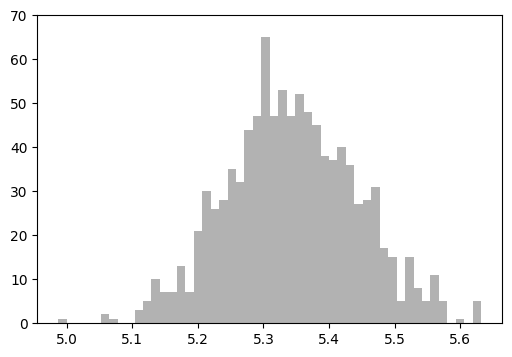

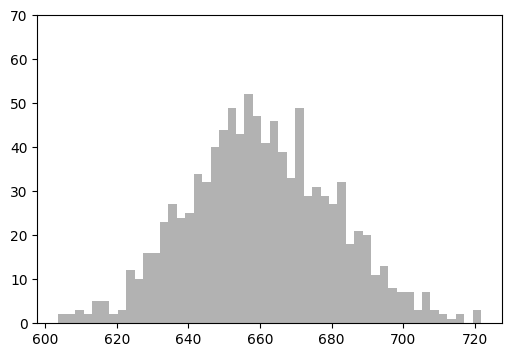

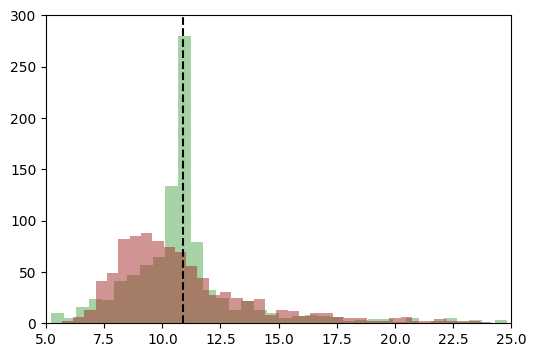

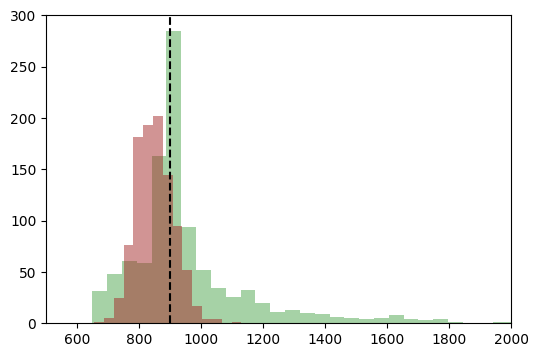

In [ ]:
# ─────────────────── Ground truth on-chip squeeziner level ───────────────────
on_chip_lin0   = (10**(-sqz_ideal_arr / 10)  - (1 - eta2_true)) / eta2_true
on_chip_db0    = np.mean(-10 * np.log10(on_chip_lin0))

on_chip_lin_raw = (10**(-sqz_numerical_arr / 10) - (1 - eta2_boot)) / eta2_boot
mask = on_chip_lin_raw > 0          # keep only physical values
on_chip_lin = on_chip_lin_raw[mask]  # drop unphysical (<0 or =0)

plt.figure(figsize=(6,4))
plt.hist(sqz_numerical_arr, bins=50, color='gray', alpha=0.6)
plt.ylim(0, 70)

save_path = save_dir+f"/Fig4a.png"
os.makedirs(os.path.dirname(save_path), exist_ok=True)
plt.savefig(save_path, dpi=1200)
plt.show()

plt.figure(figsize=(6,4))
plt.hist(shg_numerical_arr, bins=50, color='gray', alpha=0.6)
plt.ylim(0, 70)

save_path = save_dir+f"/Fig4b.png"
os.makedirs(os.path.dirname(save_path), exist_ok=True)
plt.savefig(save_path, dpi=1200)
plt.show()



######### Squeezing
# ─────────────────── Our approach for estimating on-chip squeeziner level ───────────────────
on_chip_db3    = -10 * np.log10(on_chip_lin)

plt.figure(figsize=(6,4))
plt.hist(on_chip_db3, bins=60, color='green', alpha=0.35)
plt.axvline(on_chip_db0, linestyle='--', color='black', label='Ground truth')


# ─────────────────── Conventioanl approach for estimating on-chip squeeziner level ───────────────────
etas = eta_average
on_chip_lin = (10**(-sqz_numerical_arr/10) - (1 - etas)) / etas

mask = on_chip_lin > 0          # keep only physical values
on_chip_ratio = on_chip_lin[mask]  # drop unphysical (<0 or =0)

on_chip_db2 = -10 * np.log10(on_chip_ratio)


plt.hist(on_chip_db2, bins=60, color='brown', alpha=0.5)
plt.ylim(0, 300)
plt.xlim(5,25)

save_path = save_dir+f"/Fig4c.png"
os.makedirs(os.path.dirname(save_path), exist_ok=True)
plt.savefig(save_path, dpi=1200)

plt.show()



######### SHG
# ─────────────────── Our approach for estimating on-chip SHG efficiency ───────────────────
plt.figure(figsize=(6,4))
plt.hist(shg_numerical_arr / eta1_boot, bins=50, color='green', alpha=0.35)
plt.axvline(np.mean(shg_ideal_arr/eta_1_true), linestyle='--', color='black', label='Ground truth')


# # ─────────────────── Conventioanl approach for estimating on-chip squeeziner level ───────────────────
etas = eta_average
plt.hist(shg_numerical_arr / etas, bins=15, color='brown', alpha=0.5)
plt.ylim(0, 300)
plt.xlim(500,2000)

save_path = save_dir+f"/Fig4d.png"
os.makedirs(os.path.dirname(save_path), exist_ok=True)
plt.savefig(save_path, dpi=1200)

plt.show()


